In [1]:
import swmmAPI_v2 as sm
# import mbc_v3 as mbc
from pyswmm import Simulation, Links, Nodes
import numpy as np

import swmmtoolbox.swmmtoolbox as sb
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
swmmINP = 'NoWestside_withISDs_RainEvents_Simplifying_other2.inp'
# swmmINP = 'NoWestside_withISDs_RainEvents_NoControl1.inp'
outF = 'GAopt_with_VR.out'

offset = -479.755 # To Detroit datum
control = True
control_step = 0 # seconds between actions 

In [3]:
model = sm.swmmINP(swmmINP)
model.set_dicts()
model.set_geo_dicts()
# model.convert(7.0)

In [4]:
ControlPoints = sm.make_control_points('input_files/ControlPoints-Copy.csv')
DownstreamPoints = sm.make_downstream_points('input_files/Downstream_Init_FV.csv')
for c in ControlPoints:
    c.get_model_info(model)
for d in DownstreamPoints:
    d.get_model_info(model)

2909 storage
1715 link
1686 link


In [5]:
for c in ControlPoints:
    print(c.u_name,c.u_param, c.location)
    
for d in DownstreamPoints:
    d.set_point = 0.75
    d.epsilon = 1.0
    print(d.d_name, d.epsilon, d.set_point)

17311 0.684 17311 -- CC Forebay
5220 0.029 5220 -- Freud Storm PS
5010 0.097 5010 -- CC PS to RTB
5010 0.65 5010 -- CC PS to DRI
2909 0.419 2909 -- CC RTB Dewatering
2912 1.0 2912 --CC Forebay Reguator Gates
1700 0.459 1700 -- Fairview PS
2909 1.0 0.75
1715 1.0 0.75
1686 1.0 0.75


In [6]:
for d in DownstreamPoints:
    if d.d_type == 'link':
        print(d.max_depth)
        pass
    else:
        d.dmi['q_full'] = d.max_depth
        
    print(d.d_name,d.dmi['q_full'])

2909 22.0
9.0
1715 215.30511267851173
18.02
1686 287.2985565309093


In [7]:
set_real = dict()

for c in ControlPoints:
    set_real[c.c_name] = []

In [8]:
%%time
with Simulation(swmmINP,outputfile = outF) as sim:
    run = sm.system(sim,offset = offset, control = control, control_step = control_step) # Offset = 0, by default
    run.timestep = model.options['ROUTING_STEP']
    nodes = Nodes(sim)
    links = Links(sim)
    
    
    
    run.groups = max(d.group for d in DownstreamPoints)
    
    for c in ControlPoints:
        c.set_vars(nodes,links)
    for d in DownstreamPoints:
        d.set_vars(nodes,links)
    
    
    # DO ONCE
    for d in DownstreamPoints:
        run.group_lookup[d.group] = d.d_type
    run.group_lookup

    n = len(ControlPoints)
    link_mask = np.zeros((1,n))
    storage_mask = np.zeros((1,n))
    for c,i in zip(ControlPoints,range(0,n)):
        if run.group_lookup[c.group] == 'link':
            link_mask[0,i] = 1.0
        elif run.group_lookup[c.group] == 'storage':
            storage_mask[0,i] = 1.0
        else:
            print('Check out', c.c_name, 'neither link nor storage')

    # make group matrix. dimensions of matrix are [ # of groups , # of Control Elements ]
    # Put 1 in row if Control Element is part of group
    groupM = np.zeros((run.groups,n))
    for c,i in zip(ControlPoints,range(0,n)):
        groupM[c.group-1,i] = 1

    # Make arrays for price calculations
    uparam = np.array([c.u_param for c in ControlPoints])
    dparam = np.array([d.epsilon for d in DownstreamPoints]) # Do Once
    setpts = np.array([d.set_point for d in DownstreamPoints]) # Do Once
    n_tanks_1 = np.sum(groupM,axis=1)+1 # Do once
    q_goals = [c.q_goal for c in ControlPoints]
    q_full = [d.dmi['q_full'] for d in DownstreamPoints]
    max_depth = np.array([d.max_depth for d in DownstreamPoints])
    set_and_full = setpts * q_full # Do once.
    
    
    run.last_action = sim.start_time
    
    print('Running Simulation...')
    for step in sim:
        for c in ControlPoints:
            set_real[c.c_name].append((c.q_goal,c.c_var.flow))
        
        take_action = False
        b = sim.current_time - run.last_action
        if b.total_seconds() >= run.control_step:
            take_action = True
        
        if run.control and take_action:
            run.last_action = sim.current_time
            
            ustream = np.array([c.u_var.depth / c.max_depth for c in ControlPoints])
            Uprods = uparam*ustream
            # Sum of Uparam*Ustream for each group
            np.mat(Uprods)*np.mat(groupM).transpose()

            dstream = np.array([d.d_var.depth / d.max_depth for i in DownstreamPoints])
            d_calcs = ( dstream -setpts ) * dparam # If dstream > set, P increases

            # Pareto Price for each market
            P = (np.mat(Uprods)*np.mat(groupM).transpose() + d_calcs)/ n_tanks_1
            # Give pareto price of respective group to all elements
            Pmat = np.mat(P) * np.mat(groupM)
            # Calculate individual element demands
            Pdemand = -Pmat + Uprods
            Pdemand[Pdemand < 0] = 0
            # Supply for each group
            PS = Pdemand * np.mat(groupM).transpose()

            # q_goal if all were links
            check_zero = np.divide(set_and_full, PS, out=np.zeros_like(PS), where=PS!=0)
            q_links = np.array(check_zero * groupM )* np.array( Pdemand )

            # q_goal if all were storages
            q_storage = np.array(Pdemand) * np.array( np.mat(max_depth/run.timestep) * groupM )

            # Apply masks and add together for final q_goals
            q_links = q_links * link_mask
            q_storage = q_storage * storage_mask
            q_goal = q_links + q_storage

            # Assign and send
            for q,c in zip(np.ndenumerate(q_goal),ControlPoints):
                c.q_goal = q[1] # q is a tuple with [0] index of array and [1] the value
                c.get_target_setting(run,nodes,links)
                
            run.actions.append([c.action for c in ControlPoints])
                
        else:
            for c in ControlPoints:
                c.check_flooding(run,nodes,links)

run.flood_count = sum(c.flood_count for c in ControlPoints)
print(run.flood_count)
print("Done")

{'offset': -479.755, 'control': True, 'control_step': 0}
storage
link
link
Running Simulation...
16608.0
Done
Wall time: 28min 42s


        No Control, All outfalls:  19553.847839352435 WRRF:  393739.3914194107
           Control, All outfalls:  29032.72063160814 WRRF:  225206.74062395096
Total Volume Reductions Outfalls:  -9478.872792255705 WRRF:  168532.65079545975


C:\Users\Hail\Miniconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


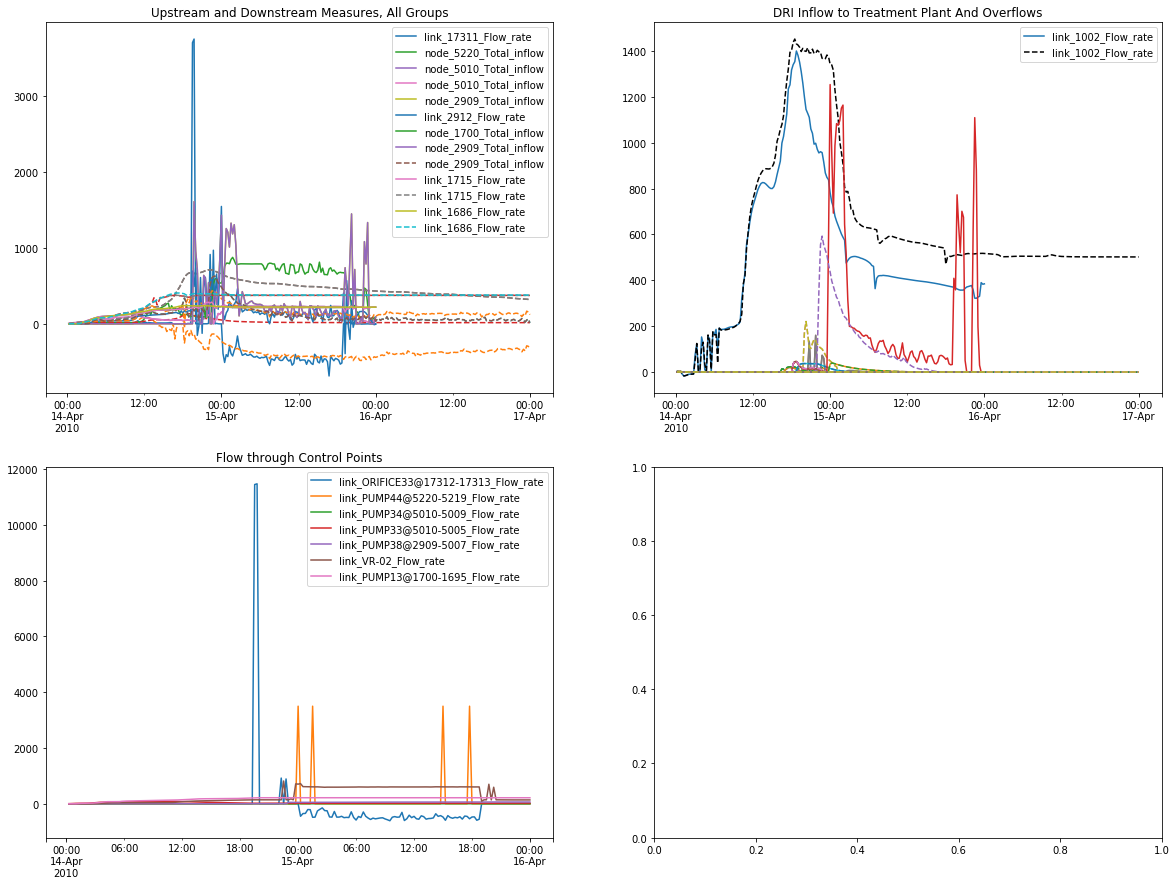

In [9]:
# cF = 'FV_Control_20170504_GA_Opt.out'
# cF = 'HoF_20150530_8223.0_5260008.824294746.out'

cF = outF
nF = 'FV_noControl_20170504.out'

fig,ax = plt.subplots(2,2,figsize=(20,15))

# Plot 1: Inflow to WRRF and all overflows for control and no control
c = []
c100 = []
n = []
n100 = []
sb.extract(cF,'link,1002,Flow_rate').plot(ax=ax[0,1])
sb.extract(nF,'link,1002,Flow_rate').plot(ax=ax[0,1],style='--',color='k')
for out in model.outfalls:
    if out != '100' and out != '200':
        i = sb.extract(cF,'node,{},Total_inflow'.format(out))
        i.plot(ax=ax[0,1],legend=False)
        c.append(i['node_{}_Total_inflow'.format(out)].sum())
        
        i = sb.extract(nF,'node,{},Total_inflow'.format(out))
        i.plot(ax=ax[0,1],legend=False, style='--')
        n.append(i['node_{}_Total_inflow'.format(out)].sum())
        
    else:
        i = sb.extract(cF,'node,{},Total_inflow'.format(out))
        c100.append(i['node_{}_Total_inflow'.format(out)].sum())
        
        i = sb.extract(nF,'node,{},Total_inflow'.format(out))
        n100.append(i['node_{}_Total_inflow'.format(out)].sum())
        
ax[0,1].set_title('DRI Inflow to Treatment Plant And Overflows')        

print('        No Control, All outfalls: ', str(sum(n)), 'WRRF: ', str(sum(n100)))
print('           Control, All outfalls: ', str(sum(c)), 'WRRF: ', str(sum(c100)))
a = sum(n) - sum(c)
b = sum(n100) - sum(c100)
print('Total Volume Reductions Outfalls: ', str(a), 'WRRF: ', str(b))



for c in ControlPoints:
    # Plot 2: Upstream and Downstream for all groups
#     sb.extract(cF,sm.make_extract_string(c.u_name,c.u_type,'depth')).plot() If expecting nodes and links
    sb.extract(cF,sm.make_extract_string(c.u_name,c.u_type,'flow')).plot(ax=ax[0,0])
    sb.extract(nF,sm.make_extract_string(c.u_name,c.u_type,'flow')).plot(ax=ax[0,0],style='--',legend=False)
#     sb.extract(nF,sm.make_extract_string(c.u_name,c.u_type,'depth')).plot(ax=ax[0,0],style='--',legend=False)

    # Plot 3: Flow through control points, for control
    sb.extract(cF,sm.make_extract_string(c.c_name,'link','flow')).plot(ax=ax[1,0])

for d in DownstreamPoints:
    sb.extract(cF,sm.make_extract_string(d.d_name,d.d_type,'flow')).plot(ax=ax[0,0])
    sb.extract(nF,sm.make_extract_string(d.d_name,d.d_type,'flow')).plot(ax=ax[0,0],style='--')
ax[0,0].set_title('Upstream and Downstream Measures, All Groups')
ax[1,0].set_title('Flow through Control Points')

fig.show()

1


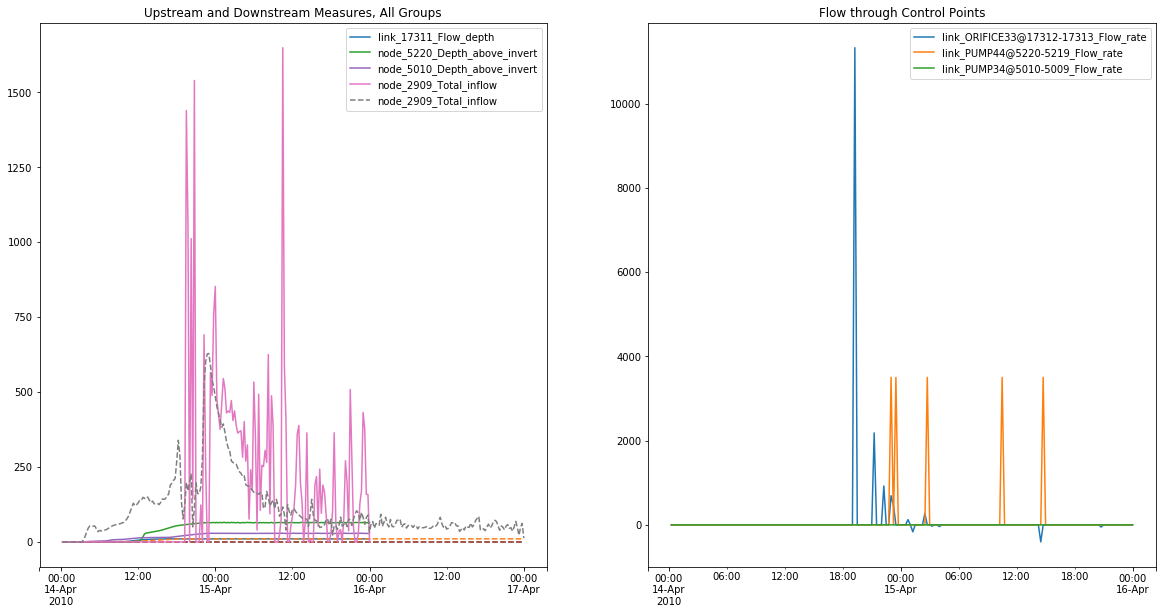

2


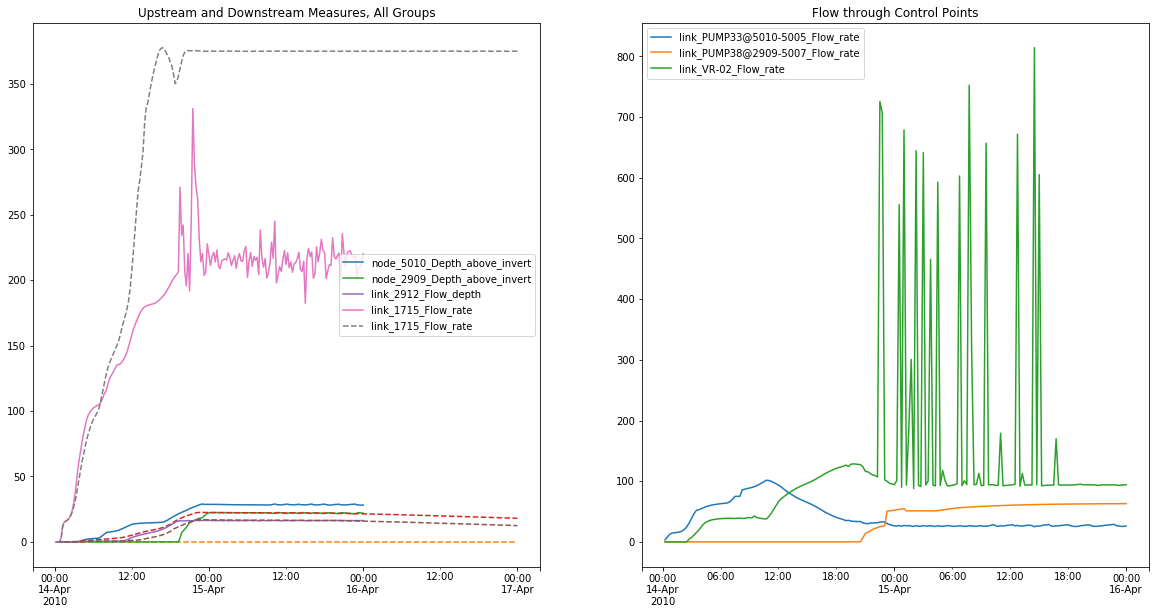

3


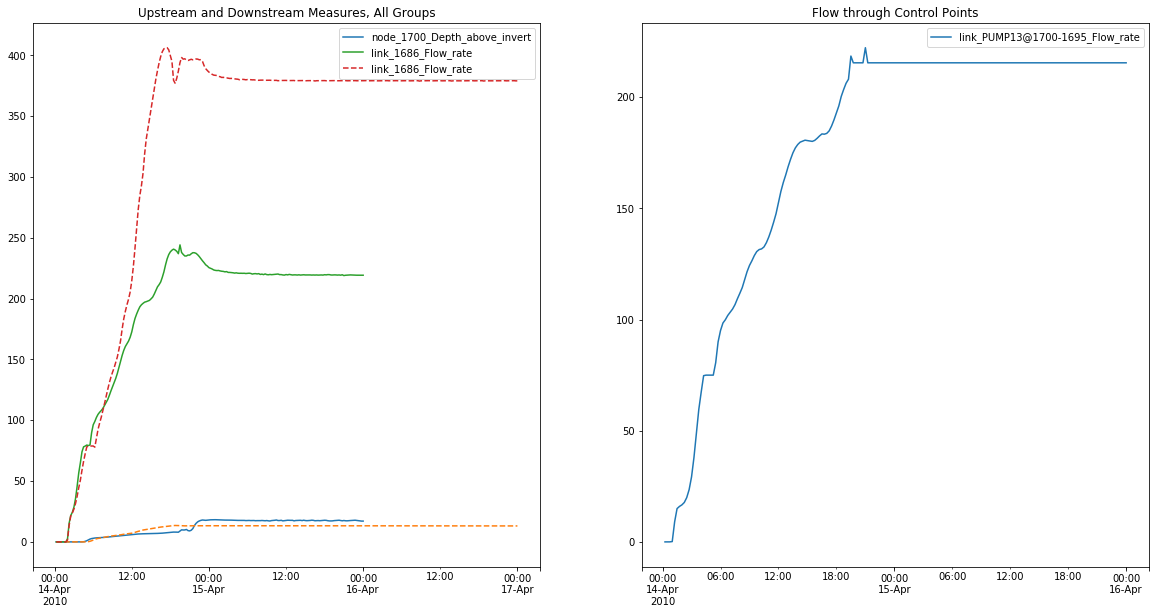

In [35]:
for r in range(1,run.groups+1):
    print(r)
    cps = [i for i in ControlPoints if i.group == r]
    dps = [i for i in DownstreamPoints if i.group == r] # for now, return 1.
    
    make_group_fig(cps,dps)

In [34]:
def make_group_fig(cps,dps):
    fig,ax = plt.subplots(1,2,figsize=(20,10))
    
    
    for c in cps:
        # Plot 2: Upstream and Downstream for all groups
#         sb.extract(cF,sm.make_extract_string(c.u_name,c.u_type,'cap')).plot(ax=ax[0])
        sb.extract(cF,sm.make_extract_string(c.u_name,c.u_type,'depth')).plot(ax=ax[0])
        sb.extract(nF,sm.make_extract_string(c.u_name,c.u_type,'depth')).plot(ax=ax[0],style='--',legend=False)
#         sb.extract(nF,sm.make_extract_string(c.u_name,c.u_type,'cap')).plot(ax=ax[0],style='--',legend=False)

        # Plot 3: Flow through control points, for control
        sb.extract(cF,sm.make_extract_string(c.c_name,'link','flow')).plot(ax=ax[1])

    for d in dps:
        sb.extract(cF,sm.make_extract_string(d.d_name,d.d_type,'flow')).plot(ax=ax[0])
        sb.extract(nF,sm.make_extract_string(d.d_name,d.d_type,'flow')).plot(ax=ax[0],style='--')
    ax[0].set_title('Upstream and Downstream Measures, All Groups')
    ax[1].set_title('Flow through Control Points')

    
    plt.show()
    return

In [9]:
%%time
with Simulation(swmmINP,outputfile = outF) as sim:
    run = sm.system(sim,offset = offset, control = control) # Offset = 0, by default
    run.timestep = model.options['ROUTING_STEP']
    nodes = Nodes(sim)
    links = Links(sim)
    
    run.groups = max(d.group for d in DownstreamPoints)
    
    for c in ControlPoints:
        c.set_vars(nodes,links)
    for d in DownstreamPoints:
        d.set_vars(nodes,links)
        
    print('Running Simulation...')
    for step in sim:
        if run.control:
            for group in range(1,run.groups+1):
                cps = [i for i in ControlPoints if i.group == group]
                dps = [i for i in DownstreamPoints if i.group == group] # for now, return 1.
                mbc.calc_actions(cps,dps,run) # Finds price, sets action for each CP as f(p)
            
            for c in ControlPoints:
                c.get_target_setting(run,nodes,links)

run.flood_count = sum(c.flood_count for c in ControlPoints)
print("Done")

{'offset': -479.755, 'control': True}
link
link
link
link
Running Simulation...
Done
Wall time: 34min 25s


In [10]:
set_real.keys()

dict_keys(['ORIFICE33@17312-17313', 'PUMP44@5220-5219', 'PUMP34@5010-5009', 'PUMP33@5010-5005', 'PUMP38@2909-5007', 'VR-02', 'PUMP13@1700-1695'])

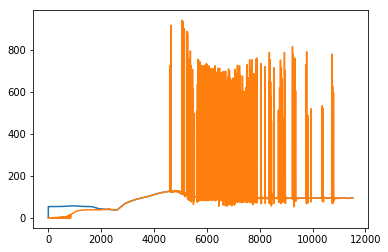

In [29]:
pump = []
goal = []
flow = []
for k in set_real['VR-02']:
    goal.append(k[0])
    flow.append(k[1])
    
plt.plot(goal)
plt.plot(flow)

In [30]:
# plt.plot(goal)
# plt.plot(flow)

import numpy as np

residual = np.array(goal) - np.array(flow)

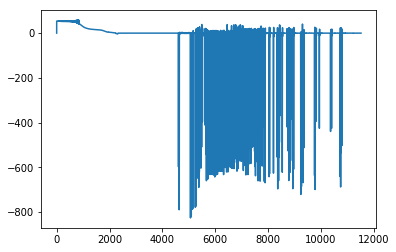

In [31]:
plt.plot(residual)

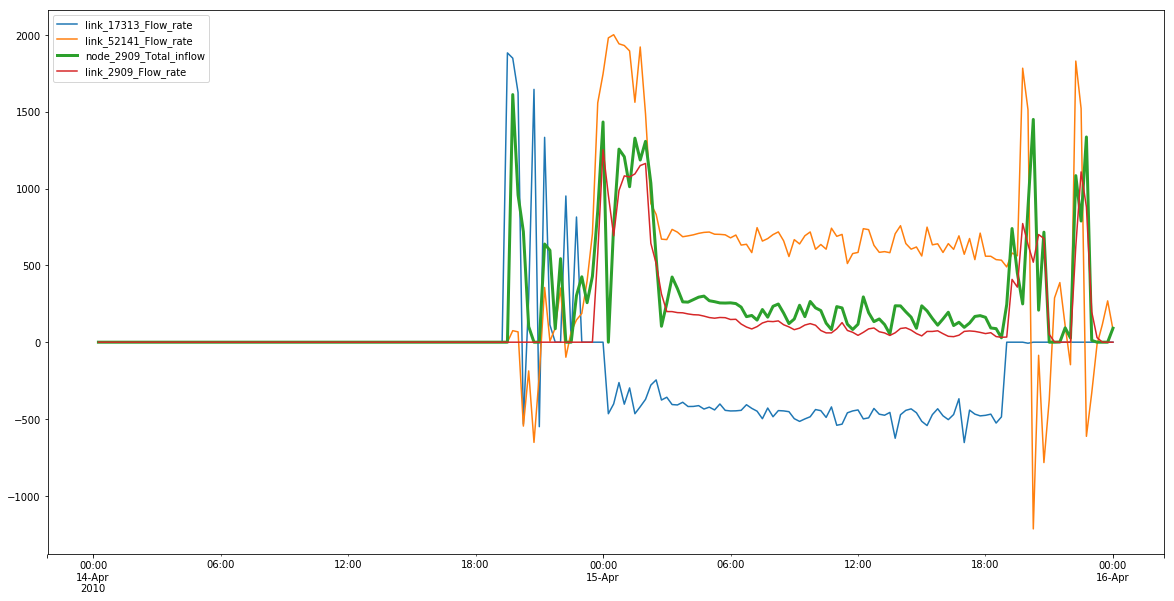

In [11]:
fig,ax = plt.subplots(figsize=(20,10))

sb.extract('GAopt_with_VR.out',sm.make_extract_string('17313','link','flow')).plot(ax=ax)
sb.extract('GAopt_with_VR.out',sm.make_extract_string('52141','link','flow')).plot(ax=ax)

sb.extract('GAopt_with_VR.out',sm.make_extract_string('2909','storage','flow')).plot(ax=ax, linewidth=3.0)


sb.extract('GAopt_with_VR.out',sm.make_extract_string('2909','link','flow')).plot(ax=ax)


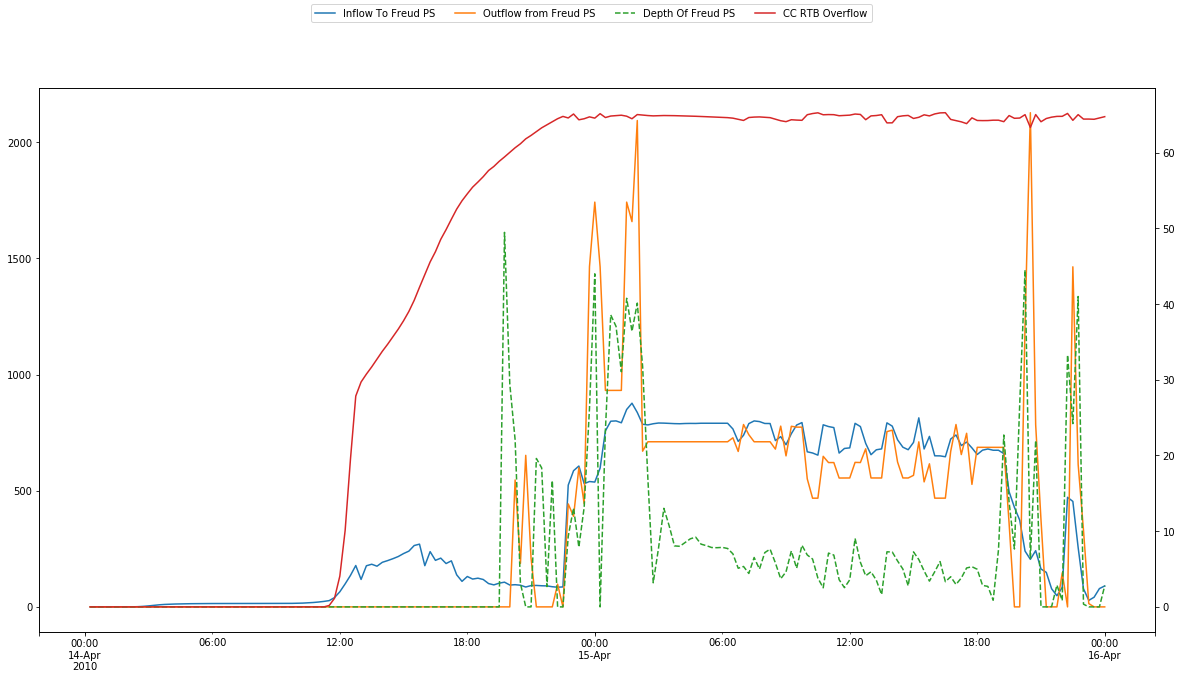

In [40]:
fig,ax = plt.subplots(figsize=(20,10))

sb.extract('GAopt_with_VR.out',sm.make_extract_string('5220','storage','flow')).plot(ax=ax,legend=False)
sb.extract('GAopt_with_VR.out',sm.make_extract_string('5215','storage','flow')).plot(ax=ax,legend=False)
sb.extract('GAopt_with_VR.out',sm.make_extract_string('2909','storage','flow')).plot(ax=ax,linestyle='--',legend=False)
sb.extract('GAopt_with_VR.out',sm.make_extract_string('5220','storage','depth')).plot(ax=ax,secondary_y=True,legend=False)

# sb.extract('GAopt_with_VR.out',sm.make_extract_string('2999','storage','depth')).plot(ax=ax,secondary_y=True)

fig.legend(['Inflow To Freud PS','Outflow from Freud PS','Depth Of Freud PS','CC RTB Overflow'],loc=9,ncol=4)